In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm
import importlib
import src.train_functions
import src.utils
import src.models

importlib.reload(src.train_functions)
importlib.reload(src.utils)
importlib.reload(src.models)

from src.train_functions import train_step, val_step, test_step
from src.utils import load_data, set_seed, save_model,load_model, parameters_to_double
from src.models import LogisticModel

![hola](data/Screenshot2024-09-10at17.19.32.png)

In [2]:
df = pd.read_csv('data/Loan_default.csv')
df.head()

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


# Data processing

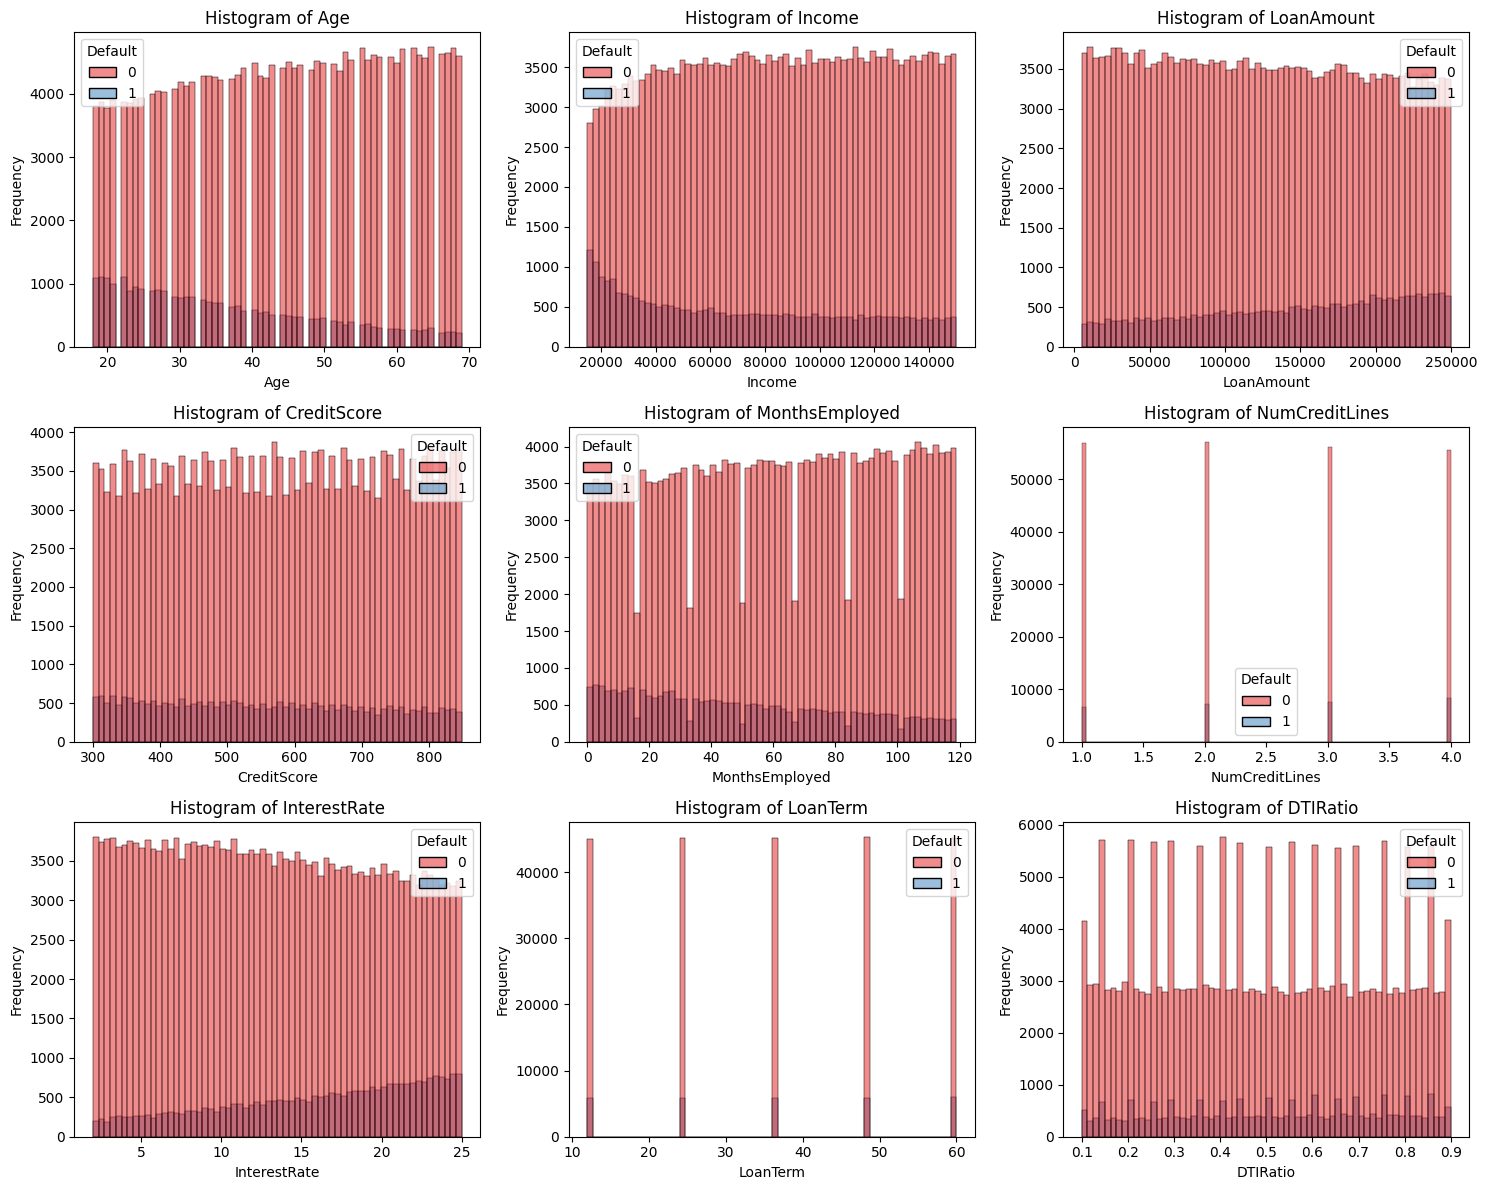

In [3]:



# Plotting the histogram with seaborn
columns_to_plot = ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed',
                   'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio']

# Create subplots
num_columns = len(columns_to_plot)
plt.figure(figsize=(15, 12))

# Loop over the columns and create a histogram for each
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(3, 3, i)  # Adjust subplot grid (3x3) according to the number of columns
    sns.histplot(data=df, x=column, hue='Default', multiple='layer', palette='Set1', kde=False)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

In [4]:
# One-hot encoding
df_encoded = pd.get_dummies(df, columns=['Education', 'EmploymentType', 'MaritalStatus', 'LoanPurpose'])


In [5]:
# specify the order of the categories
quality_map = {'Yes': 1, 'No': 0}

df_encoded['HasMortgage'] = df_encoded['HasMortgage'].map(quality_map)
df_encoded['HasCoSigner'] = df_encoded['HasCoSigner'].map(quality_map)
df_encoded['HasDependents'] = df_encoded['HasDependents'].map(quality_map)
bool_columns = ["Education_Bachelor's", 'Education_High School', "Education_Master's",
       'Education_PhD', 'EmploymentType_Full-time', 'EmploymentType_Part-time',
       'EmploymentType_Self-employed', 'EmploymentType_Unemployed',
       'MaritalStatus_Divorced', 'MaritalStatus_Married',
       'MaritalStatus_Single', 'LoanPurpose_Auto', 'LoanPurpose_Business',
       'LoanPurpose_Education', 'LoanPurpose_Home', 'LoanPurpose_Other']
df_encoded[bool_columns] = df_encoded[bool_columns].astype(int)




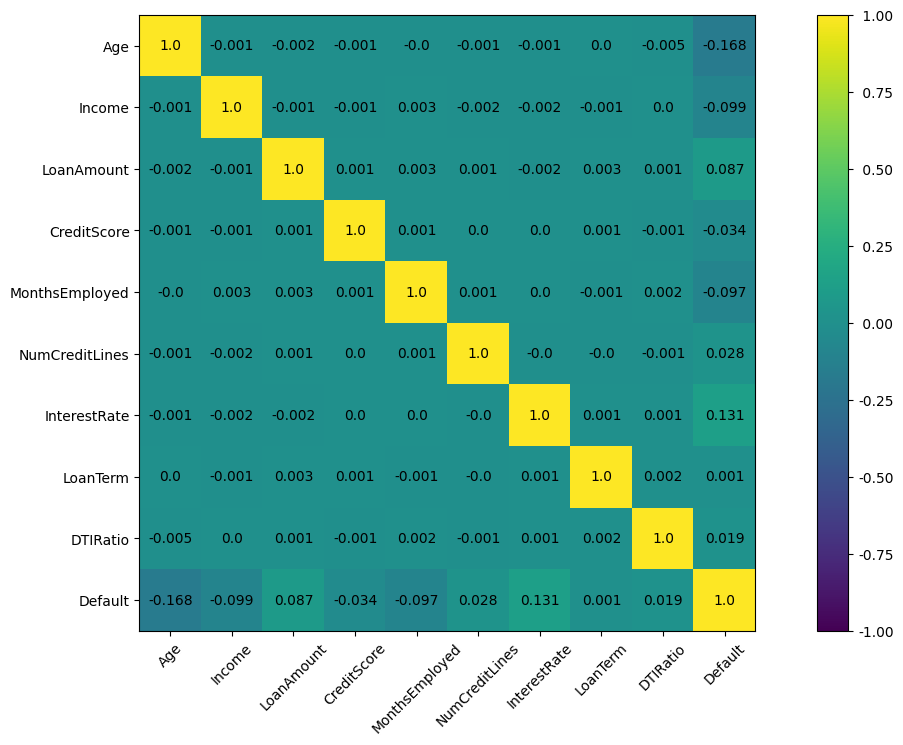

In [6]:
corr_matrix = df.select_dtypes(include=[np.number]).corr()

fig, ax = plt.subplots(figsize=(16, 8))
im = ax.imshow(corr_matrix)
im.set_clim(-1, 1)
ax.grid(False)
ax.xaxis.set(ticks=[i for i in range(len(corr_matrix))], ticklabels=corr_matrix.columns)
ax.yaxis.set(ticks=[i for i in range(len(corr_matrix))], ticklabels=corr_matrix.columns)
# ax.set_ylim(2.5, -0.5)
for i, col1 in enumerate(corr_matrix.columns):
    for j, col2 in enumerate(corr_matrix.columns):
        ax.text(j, i, round(corr_matrix[col1][col2], 3), ha='center', va='center',
                color='black')
cbar = ax.figure.colorbar(im, ax=ax, format='% .2f')
plt.xticks(rotation=45)
plt.show()

There is no clear correlation between any of the variables

In [7]:
df_encoded = df_encoded.drop('LoanID', axis=1)

In [14]:
set_seed(42)

# set device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


"""
This function is the main program for training.
"""

# probar con más epochs los mejores 3 modelos

# hyperparameters
epochs: int = 10
lr: float = 3e-2
batch_size: int = 1024
hidden_sizes: tuple[int, ...] = [] #(128, 64)

# empty nohup file
open("nohup.out", "w").close()

# load data
train_data: DataLoader
val_data: DataLoader
train_data, val_data, _ = load_data(df_encoded, batch_size=batch_size)

# define name and writer
name: str = f"model_logistic_lr_{lr}_bs_{batch_size}_hs_{hidden_sizes}_{epochs}"
writer: SummaryWriter = SummaryWriter(f"runs/{name}")

# define model
inputs: torch.Tensor = next(iter(train_data))[0]
model: torch.nn.Module = LogisticModel(
    inputs.shape[1], hidden_sizes,
).to(device)
parameters_to_double(model)

# compute class weights
class_counts = torch.tensor([80, 20])  # Example counts of class 0 and class 1

# Inverse frequency
class_weights = 1.0 / class_counts.float()
# Normalize weights to sum to 1 if desired (optional)
class_weights = class_weights / class_weights.sum()


# define loss and optimizer
# loss: torch.nn.Module = torch.nn.BCELoss(weight=class_weights[1].to(device))
loss: torch.nn.Module = torch.nn.BCELoss()
optimizer: torch.optim.Optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0.01)

# train loop
for epoch in tqdm(range(epochs)):
    # call train step
    train_step(model, train_data, loss, optimizer, writer, epoch, device)

    # call val step
    val_step(model, val_data, loss, writer, epoch, device)

# save model
save_model(model, name)





100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


In [12]:
# TODO: outliers
# TODO: automatizar proceso de los .py
# TODO: generalizar el batch size y todos los parametros
# TODO: analisis exploratorio de los resultados (F1 score y matriz)
# TODO: probar más capas (generalizarlo)
# TODO: añadir semilla al random_split

In [15]:

def main(name: str) -> float:
    """
    This function is the main program for the testing.
    """

    # load data
    test_data: DataLoader
    _, _, test_data = load_data(df_encoded, batch_size=1024)

    # define name and writer

    # define model
    model = load_model(f"{name}").to(device)

    # call test step and evaluate accuracy
    accuracy, f1, conf_matrix = test_step(model, test_data, device)

    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print(f"Confusion Matrix:\n{conf_matrix}")

    return accuracy, f1, conf_matrix


if __name__ == "__main__":
    main(name)


Accuracy: 0.7991270727040817
F1 Score: 0.44417489171734625
Confusion Matrix:
[[40097     0]
 [10079     0]]
